* 1st: compute position selectivity
* 2nd: get baseline and selectivity fr 
* 3rd: compute activation index

In [8]:
import glob
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.trials import select_trials
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from ephysvibe.trials import align_trials, select_trials

In [49]:
def get_selectivity_info(neu: NeuronData):
    win = 100
    res = {}
    res["nid"] = neu.get_neuron_id()

    inout_fr = []
    inout_sp = []
    for inout in ["in", "out"]:
        sp = getattr(neu, "sample_on_" + inout)
        inout_sp.append(sp)
        fr = firing_rate.moving_average(data=sp, win=100, step=1)[:, :-win]  #
        inout_fr.append(fr)

    pos_lat, pos_score, pos_p = smetrics.get_selectivity(
        inout_fr[0], inout_fr[1], win=75, scores=True
    )
    if np.isnan(pos_lat):
        pos_selec = np.nan
        activation_in = np.nan
        activation_out = np.nan
    else:

        blin = np.mean(inout_sp[0][:,100:300])
        samplein = np.mean(inout_sp[0][:,pos_lat:pos_lat+150])
        activation_in = (samplein-blin)/(blin+samplein)
        blout = np.mean(inout_sp[1][:,100:300])
        sampleout = np.mean(inout_sp[1][:,pos_lat:pos_lat+150])
        activation_out = (sampleout-blout)/(blout+sampleout)

        if pos_score[pos_lat] > 0:
            pos_selec = "in"
        else:
            pos_selec = "out"

    res["pos_lat"] = pos_lat
    res["pos_selec"] = pos_selec
    res["pos_score"] = pos_score
    res["pos_p"] = pos_p
    res["activation_in"] = activation_in
    res["activation_out"] = activation_out

    return res


In [50]:
def get_selectivity_info_op2(neu: NeuronData):
    win = 100
    res = {}
    res["nid"] = neu.get_neuron_id()

    inout_fr = []
    inout_sp = []
    for inout in ["in", "out"]:
        sp = getattr(neu, "sample_on_" + inout)
        inout_sp.append(sp)
        fr = firing_rate.moving_average(data=sp, win=100, step=1)[:, :-win]  #
        inout_fr.append(fr)

    pos_lat, pos_score, pos_p = smetrics.get_selectivity(
        inout_fr[0], inout_fr[1], win=75, scores=True
    )
    if np.isnan(pos_lat):
        pos_selec = np.nan
        activation_in = np.nan
        activation_out = np.nan
    else:
        bl = np.concatenate((inout_sp[0][:,100:300],inout_sp[1][:,100:300]),axis=0)
        blmean = np.mean(bl) 
        samplein = np.mean(inout_sp[0][:,pos_lat:pos_lat+150]) 
        sampleout = np.mean(inout_sp[1][:,pos_lat:pos_lat+150]) 
        maxsample = np.max((samplein,sampleout))
        activation_in = (samplein-blmean)/(blmean+maxsample) 
        activation_out = (sampleout-blmean)/(blmean+maxsample) 

        if pos_score[pos_lat] > 0:
            pos_selec = "in"
        else:
            pos_selec = "out"

    res["pos_lat"] = pos_lat
    res["pos_selec"] = pos_selec
    res["pos_score"] = pos_score
    res["pos_p"] = pos_p
    res["activation_in"] = activation_in
    res["activation_out"] = activation_out

    return res

In [3]:
def get_neu_align(path, params, sp_sample=False):

    neu = NeuronData.from_python_hdf5(path)
    for it in params:
        sp, mask = neu.align_on(
            select_block=it["select_block"],
            select_pos=it["inout"],
            event=it["event"],
            time_before=it["time_before"],
            error_type=0,
        )
        endt = it["time_before"] + it["end"]
        stt = it["time_before"] + it["st"]
        setattr(neu, it["sp"], np.array(sp[:, :endt], dtype=it["dtype_sp"]))
        setattr(neu, it["mask"], np.array(mask, dtype=it["dtype_mask"]))
        setattr(neu, "st_" + it["event"] + "_" + it["inout"], np.array(stt, dtype=int))
        setattr(
            neu,
            "time_before_" + it["event"] + "_" + it["inout"],
            np.array(it["time_before"], dtype=int),
        )

    if ~sp_sample:
        setattr(neu, "sp_samples", np.array([]))

    return neu

In [4]:
# Define parameters
areas = ["lip"]
subject = "Riesling"
# paths
filepaths = {
    "lip": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/",
    "pfc": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/",
    "v4": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/neurons/",
}
savepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/activation_index/"
popu_path = {
    # "lip": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/population_selectivity_lip.h5",
    # "pfc": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/population_selectivity_pfc.h5",
    # "v4": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/population_selectivity_v4.h5",
}

In [5]:
for area in areas:
    print(area)
    if not bool(popu_path):
        path = filepaths[area]
        neu_path = path + "*neu.h5"
        path_list = glob.glob(neu_path)

        params = [
            {
                "inout": "in",
                "sp": "sample_on_in",
                "mask": "mask_in",
                "event": "sample_on",
                "time_before": 300,
                "st": 0,
                "end": 1550,
                "select_block": 1,
                "win": 100,
                "dtype_sp": np.int8,
                "dtype_mask": bool,
            },
            {
                "inout": "out",
                "sp": "sample_on_out",
                "mask": "mask_out",
                "event": "sample_on",
                "time_before": 300,
                "st": 0,
                "end": 1550,
                "select_block": 1,
                "win": 100,
                "dtype_sp": np.int8,
                "dtype_mask": bool,
            },
        ]
        population_list = Parallel(n_jobs=-1)(
            delayed(get_neu_align)(neu, params) for neu in tqdm(path_list)
        )
        comment = str(params)
        population = PopulationData(population_list, comment=comment)
        print("Saving population.h5")
        population.to_python_hdf5(savepath + "population_selectivity_" + area + ".h5")
        population = PopulationData.from_python_hdf5(
            savepath + "population_selectivity_" + area + ".h5"
        )
    else:
        print("Reading population data")
        population = PopulationData.from_python_hdf5(popu_path[area])
    print("Computing selectivity")
    df_selectivity = population.execute_function(
        get_selectivity_info, n_jobs=-1, ret_df=True
    )

    df_selectivity.to_pickle(savepath + "population_selectivity_" + area + ".pkl")

lip


  0%|          | 0/530 [00:00<?, ?it/s]

100%|██████████| 530/530 [11:46<00:00,  1.33s/it]


Saving population.h5


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/activation_index/population_selectivity_lip.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [7]:
population.to_python_hdf5(savepath + "population_selectivity_" + area + ".h5")
population = PopulationData.from_python_hdf5(
    savepath + "population_selectivity_" + area + ".h5"
)

In [5]:
population = PopulationData.from_python_hdf5("population_selectivity_lip.h5")

In [9]:
def get_sorted_scores(score,latencies,pmask=None):
    shifts=np.where(np.isnan(latencies),0,latencies).astype(int)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        mean_score = np.nanmean(align_trials.indep_roll(arr=score, shifts=-shifts, axis = 1)[:,:200],axis=1)
    mean_score[np.isnan(mean_score)]=0
    positive_mask = mean_score>=0
    negative_mask = mean_score<0

    positive_sorted_idx = np.argsort(latencies[positive_mask])
    negative_sorted_idx = np.argsort(latencies[negative_mask])

    sorted_neg_scores = score[negative_mask][negative_sorted_idx]
    sorted_pos_scores = score[positive_mask][positive_sorted_idx][::-1]
    sorted_scores = np.concatenate((sorted_neg_scores,sorted_pos_scores),axis=0)

    sorted_neg_latencies = latencies[negative_mask][negative_sorted_idx]
    sorted_pos_latencies = latencies[positive_mask][positive_sorted_idx][::-1]
    sorted_latencies = np.concatenate((sorted_neg_latencies,sorted_pos_latencies),axis=0)
    sorted_pmask=None
    if pmask is not None:
        sorted_neg_pmask = pmask[negative_mask][negative_sorted_idx]
        sorted_pos_pmask = pmask[positive_mask][positive_sorted_idx][::-1]
        sorted_pmask = np.concatenate((sorted_neg_pmask,sorted_pos_pmask),axis=0)

    return sorted_scores, sorted_latencies,sorted_pmask

In [10]:
def plot_latencies(df,lat_key,score_key,ax,max_len=1750,p_key=None):
    
    lat = df[score_key].values.tolist()
    if p_key is not None:
        p = df[p_key].values.tolist()
        padded_p = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in p]
        pmask = np.array(padded_p)>0.05
    else:
        pmask=None
    #lists = [lst if isinstance(lst, np.ndarray) else np.array([]) for lst in lat]
    padded_lists = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in lat]
    score=np.array(padded_lists)
    latencies = df[lat_key].values
    sorted_scores, sorted_latencies,pmask = get_sorted_scores(score,latencies,pmask)
    sns.heatmap(sorted_scores, vmin=-1, vmax=1, cmap='PiYG',ax=ax,mask=pmask)
    ax.scatter(sorted_latencies,np.arange(len(sorted_latencies))+0.5,s=0.4,color='k')
    x_ticks = np.arange(0,sorted_scores.shape[1],50)
    ax.set_xticks(x_ticks)
    _=ax.set_xticklabels(x_ticks- 300 )
    ax.vlines([300,450+300,850+300],ax.get_ylim()[0],ax.get_ylim()[1],'k','--')
    ax.set_title(lat_key)
    return latencies

In [ ]:
print("Computing selectivity")
df_selectivity = population.execute_function(
    get_selectivity_info_op2, n_jobs=-1, ret_df=True
)

In [30]:
df_selectivity

,nid,pos_lat,pos_selec,pos_score,pos_p,activation_in,activation_out
0,good1LIP2022-12-01_10-23-18Riesling,310.0,in,"[0.020000000000000018, 0.040000000000000036, 0...","[0.5388744453696104, 0.5375822759843675, 0.730...",0.617830,-0.039237
1,mua3LIP2022-11-22_10-59-03Riesling,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020...","[0.5202465096303022, 0.5202465096303024, 0.520...",NaN,NaN
2,mua2LIP2023-01-23_10-10-27Riesling,1026.0,in,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8734586720175761, 0.8734586720175761, 0.762...",0.130867,-0.371860
3,good4LIP2023-01-23_10-10-27Riesling,661.0,in,"[0.020000000000000018, 0.040000000000000036, 0...","[0.48270372215942525, 0.38890044981696414, 0.5...",0.090248,-0.112567
4,good5LIP2023-01-23_10-10-27Riesling,NaN,NaN,"[-0.020000000000000018, -0.020000000000000018,...","[0.25991255105111677, 0.2599125510511169, 0.25...",NaN,NaN
...,...,...,...,...,...,...,...
525,mua4LIP2023-01-18_10-22-38Riesling,359.0,in,"[0.020000000000000018, 0.020000000000000018, 0...","[0.778551307552657, 0.778551307552657, 0.77855...",0.770814,0.131469
526,mua1LIP2023-01-23_10-10-27Riesling,219.0,out,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9139703997516819, 0.7715443201012389, 0.733...",-0.307780,-0.132980
527,good1LIP2023-01-23_10-10-27Riesling,758.0,out,"[-0.020000000000000018, -0.040000000000000036,...","[0.11729149269388141, 0.09549141394529437, 0.1...",0.295066,0.600823
528,good2LIP2023-01-23_10-10-27Riesling,1244.0,in,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5946433923115773, 0.7209681733469, 0.720968...",0.377496,-0.182930


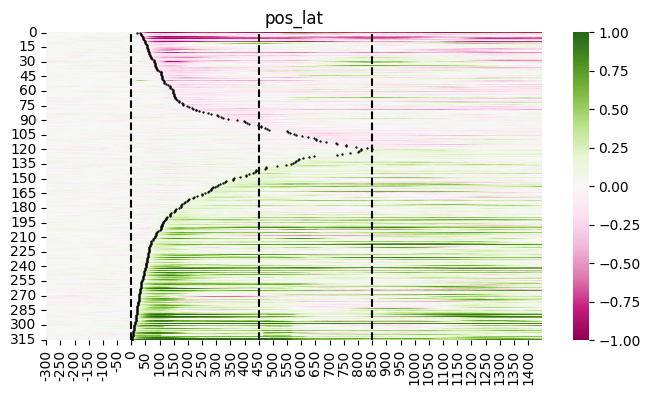

In [63]:
max_len=1750

df_sel=df_selectivity[np.logical_and(df_selectivity['pos_lat']>0+300,df_selectivity['pos_lat']<850+300)]

f,ax=plt.subplots(figsize=(8,4),sharex=True)
latencies = plot_latencies(df_sel,lat_key='pos_lat',score_key='pos_score',ax=ax)


In [64]:
df_sel=df_selectivity[np.logical_and(df_selectivity['pos_lat']>0+300,df_selectivity['pos_lat']<850+300)]

Text(0, 0.5, 'activation index out')

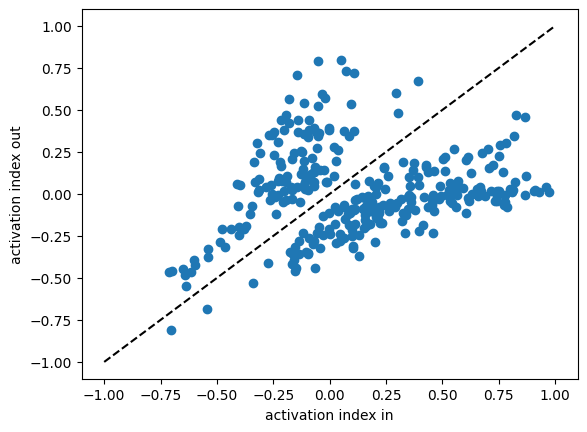

In [65]:
plt.scatter(df_sel['activation_in'].values,df_sel['activation_out'].values)
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel('activation index in')
plt.ylabel('activation index out')

Text(0, 0.5, 'activation index out')

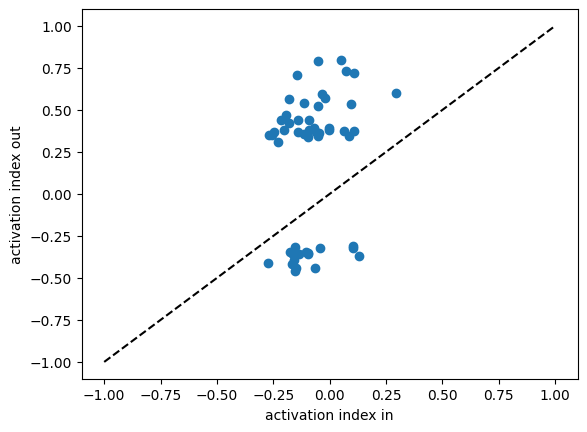

In [66]:
aa=df_sel[np.logical_and(np.abs(df_sel['activation_in'])<0.30,np.abs(df_sel['activation_out'])>0.30)]
plt.scatter(aa['activation_in'].values,aa['activation_out'].values)
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel('activation index in')
plt.ylabel('activation index out')

In [67]:
9/11

0.8181818181818182

In [68]:
aa

,nid,pos_lat,pos_selec,pos_score,pos_p,activation_in,activation_out
2,mua2LIP2023-01-23_10-10-27Riesling,1026.0,in,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8734586720175761, 0.8734586720175761, 0.762...",0.130867,-0.371860
13,good3LIP2023-01-26_10-45-42Riesling,406.0,out,"[0.06000000000000005, 0.06000000000000005, 0.0...","[0.11819630440361124, 0.11819630440361104, 0.1...",-0.192651,0.469588
18,mua7LIP2023-01-26_10-45-42Riesling,495.0,out,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8489617301408899, 0.8489617301408898, 0.911...",-0.145326,0.709349
19,good4LIP2023-01-26_10-45-42Riesling,335.0,out,"[0.020000000000000018, 0.020000000000000018, 0...","[0.44935880719148624, 0.44935880719148624, 0.7...",-0.050598,0.792221
39,good6LIP2022-12-01_12-01-59Riesling,517.0,out,"[-0.07999999999999996, -0.07999999999999996, -...","[0.082601434872598, 0.07010197229294972, 0.077...",-0.245618,0.369869
50,good4LIP2023-03-06_10-32-51Riesling,366.0,out,"[0.020000000000000018, 0.020000000000000018, 0...","[0.5878446050818023, 0.5878446050818027, 0.587...",-0.231081,0.308232
70,good2LIP2023-03-17_10-11-51Riesling,352.0,out,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5357646295114831, 0.5357646295114831, 0.535...",-0.052924,0.524075
79,mua4LIP2023-03-17_10-11-51Riesling,630.0,in,"[0.0, 0.0, 0.020000000000000018, 0.02000000000...","[0.5524628510655015, 0.44301221922718914, 0.43...",-0.166494,-0.414384
86,mua6LIP2023-03-20_10-39-08Riesling,706.0,in,"[0.0, -0.020000000000000018, -0.02000000000000...","[0.8989105846397357, 0.8334922111574006, 0.821...",-0.042571,-0.319496
87,good2LIP2023-03-20_10-39-08Riesling,946.0,out,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3953779627131965, 0.44634403900707253, 0.56...",-0.050882,0.342064


In [37]:
df_sel[df_sel['nid']=='good1LIP2023-02-27_10-50-03Riesling']

,nid,pos_lat,pos_selec,pos_score,pos_p,activation_in,activation_out
121,good1LIP2023-02-27_10-50-03Riesling,348.0,out,"[0.020000000000000018, 0.040000000000000036, 0...","[0.41692658538498395, 0.4020449866207977, 0.50...",-0.18091,0.565013


In [48]:
df_sel[df_sel['nid']=='mua5LIP2023-02-27_10-50-03Riesling']

,nid,pos_lat,pos_selec,pos_score,pos_p,activation_in,activation_out
126,mua5LIP2023-02-27_10-50-03Riesling,357.0,out,"[0.020000000000000018, 0.020000000000000018, 0...","[0.3102745985911349, 0.4432017023043231, 0.371...",-0.307753,0.245802


In [51]:
print("Computing selectivity")
df_selectivity1 = population.execute_function(
    get_selectivity_info, n_jobs=-1, ret_df=True
)

Computing selectivity


100%|██████████| 530/530 [06:54<00:00,  1.28it/s]


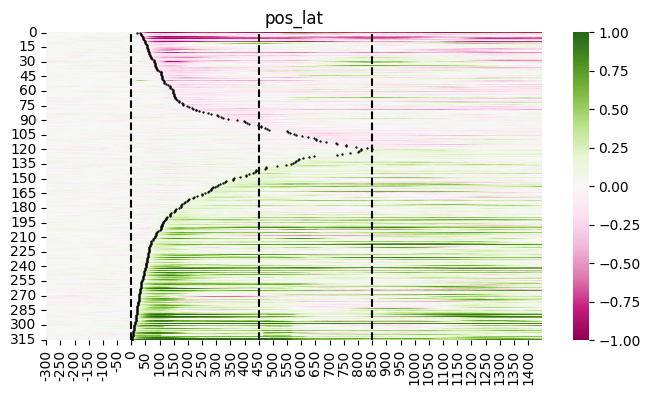

In [52]:
max_len=1750

df_sel=df_selectivity1[np.logical_and(df_selectivity1['pos_lat']>0+300,df_selectivity1['pos_lat']<850+300)]

f,ax=plt.subplots(figsize=(8,4),sharex=True)
latencies = plot_latencies(df_sel,lat_key='pos_lat',score_key='pos_score',ax=ax)

In [53]:
df_sel=df_selectivity1[np.logical_and(df_selectivity1['pos_lat']>0+300,df_selectivity1['pos_lat']<850+300)]

Text(0, 0.5, 'activation index out')

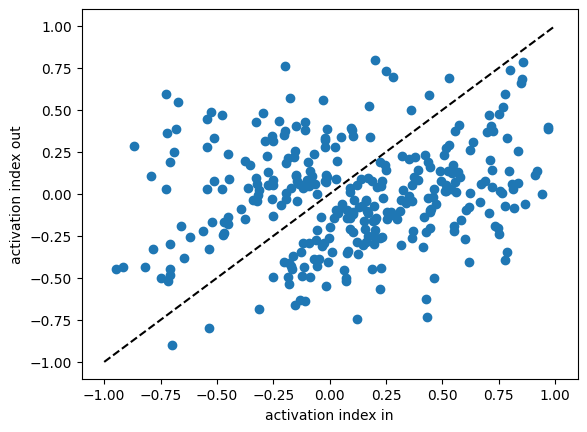

In [54]:
plt.scatter(df_sel['activation_in'].values,df_sel['activation_out'].values)
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel('activation index in')
plt.ylabel('activation index out')